In [474]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, SimpleRNN
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from datetime import date, datetime

In [59]:
def create_model(lookback,features):
    lstm_input = Input(shape=(lookback,1), name='input_time_series')
    sentiment_input = Input(shape=(3,),name = 'input_sentiments')
    other_input = Input(shape=(features,),name = 'input_other_features')
    recurrent_layer = LSTM(128,activation='tanh',return_sequences=False, return_state = False,name='recurrent_layer')(lstm_input) # 128 neurons in the LSTM layer
    processing_layer_1 = Dense(32,activation='relu')(tf.concat([recurrent_layer,sentiment_input,other_input],1))
    processing_layer_2 = Dense(64,activation='relu')(processing_layer_1)
    output_layer = Dense(1)(processing_layer_2)
    model = tf.keras.Model(inputs=[lstm_input,sentiment_input,other_input],outputs = output_layer)
    return model

Creating an instance of model

In [60]:
model = create_model(5,1)

Checking the model summary:

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_time_series (InputLayer)  [(None, 5, 1)]      0           []                               
                                                                                                  
 recurrent_layer (LSTM)         (None, 128)          66560       ['input_time_series[0][0]']      
                                                                                                  
 input_sentiments (InputLayer)  [(None, 3)]          0           []                               
                                                                                                  
 input_other_features (InputLay  [(None, 1)]         0           []                               
 er)                                                                                        

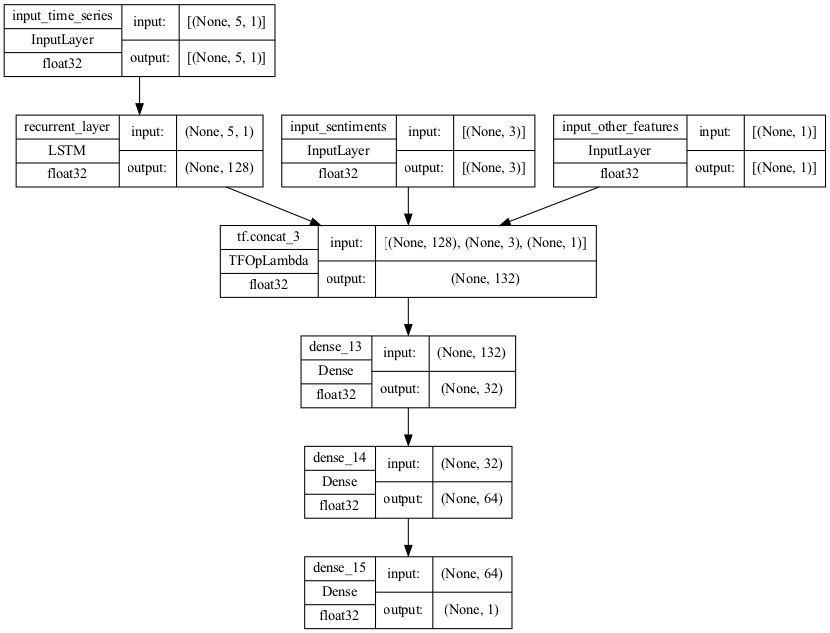

In [64]:
tf.keras.utils.plot_model(model,dpi=75,show_dtype=True,show_shapes = True)

In [78]:
test_input_1 = tf.convert_to_tensor(np.array([[1,2,3,4,5]]).reshape(1,-1,1),dtype=tf.float32)
test_input_2 = tf.convert_to_tensor(np.array([6,7,8]).reshape(1,3),dtype=tf.float32)
test_input_3 = tf.convert_to_tensor(np.array([9]).reshape(1,1),dtype=tf.float32)
test_input = tf.convert_to_tensor([1,2,3,4,5,6,7,8,9],dtype=tf.float32)

In [79]:
print(test_input_1.shape,test_input_2.shape,test_input_3.shape)

(1, 5, 1) (1, 3) (1, 1)


In [82]:
result = model.predict([test_input_1,test_input_2,test_input_3])

1/1 [==============================] - 0s 21ms/step


In [84]:
result

array([[-0.6020252]], dtype=float32)

# Creating the Model

We will create the model that takes only the data of past lookback target variables and today's sentiment values. Our basic model will not take any additional feature. The function that creates our model takes additional features. So we will just set the input variables for additional features to zero.

We will create the training and testing datasets, train the model, and test it's performance.

We will include the following regularization techiniques in our model:
1. Kernel regularization - add a term to the loss function that is proportional to the n-th power of sum of weights
2. Variational dropout - It applies dropout to the input features (input gate and cell state update) at each time step. However, instead of dropping out the same set of units for each input sequence, variational dropout samples a unique dropout mask for each sequence in the mini-batch. This means that each sequence has its own dropout mask, providing additional regularization and capturing the uncertainty in the dropout process. 
3. Recurrent dropout - Randomly drop some of the recurrent connections during training.

In [511]:
def stock_model(lookback,features):
    #input layers
    lstm_input = Input(shape=(lookback,1), name='input_time_series')
    sentiment_input = Input(shape=(3,),name = 'input_sentiments')
    other_input = Input(shape=(features,),name = 'input_other_features')
    
    #recurrent layers
    recurrent_layer_1 = SimpleRNN(64,activation='tanh',return_sequences=False, return_state = False,name='recurrent_layer_1',recurrent_dropout=0.01,dropout=0.01,kernel_regularizer=tf.keras.regularizers.L2(0.001))(lstm_input) # 128 neurons in the LSTM layer
    #recurrent_layer_2 = LSTM(32,activation='tanh',return_sequences=False, return_state = False,name='recurrent_layer_2',recurrent_dropout=0.1,dropout=0.1,kernel_regularizer=tf.keras.regularizers.L2(0.01))(recurrent_layer_1) # 128 neurons in the LSTM layer
    
    #processing layers
    processing_layer_1 = Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001))(tf.concat([recurrent_layer_1,sentiment_input,other_input],1))
    dropout_layer_1 = Dropout(0.2)(processing_layer_1)
    processing_layer_2 = Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(dropout_layer_1)
    dropout_layer_2 = Dropout(0.1)(processing_layer_2)
    processing_layer_3 = Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(dropout_layer_2)
    dropout_layer_3 = Dropout(0.01)(processing_layer_3)
    processing_layer_4 = Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(dropout_layer_3)
    dropout_layer_4 = Dropout(0.01)(processing_layer_4)
    
    
    #output layer
    output_layer = Dense(1)(dropout_layer_4)
    
    model = tf.keras.Model(inputs=[lstm_input,sentiment_input,other_input],outputs = output_layer)
    model.compile(loss='mse', optimizer=keras.optimizers.Adagrad(),metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    return model

Initializing the model with no additional features.

In [547]:
lookback = 5
model = stock_model(lookback,1)

Model Summary:

In [548]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_time_series (InputLayer)  [(None, 5, 1)]      0           []                               
                                                                                                  
 recurrent_layer_1 (SimpleRNN)  (None, 64)           4224        ['input_time_series[0][0]']      
                                                                                                  
 input_sentiments (InputLayer)  [(None, 3)]          0           []                               
                                                                                                  
 input_other_features (InputLay  [(None, 1)]         0           []                               
 er)                                                                                       

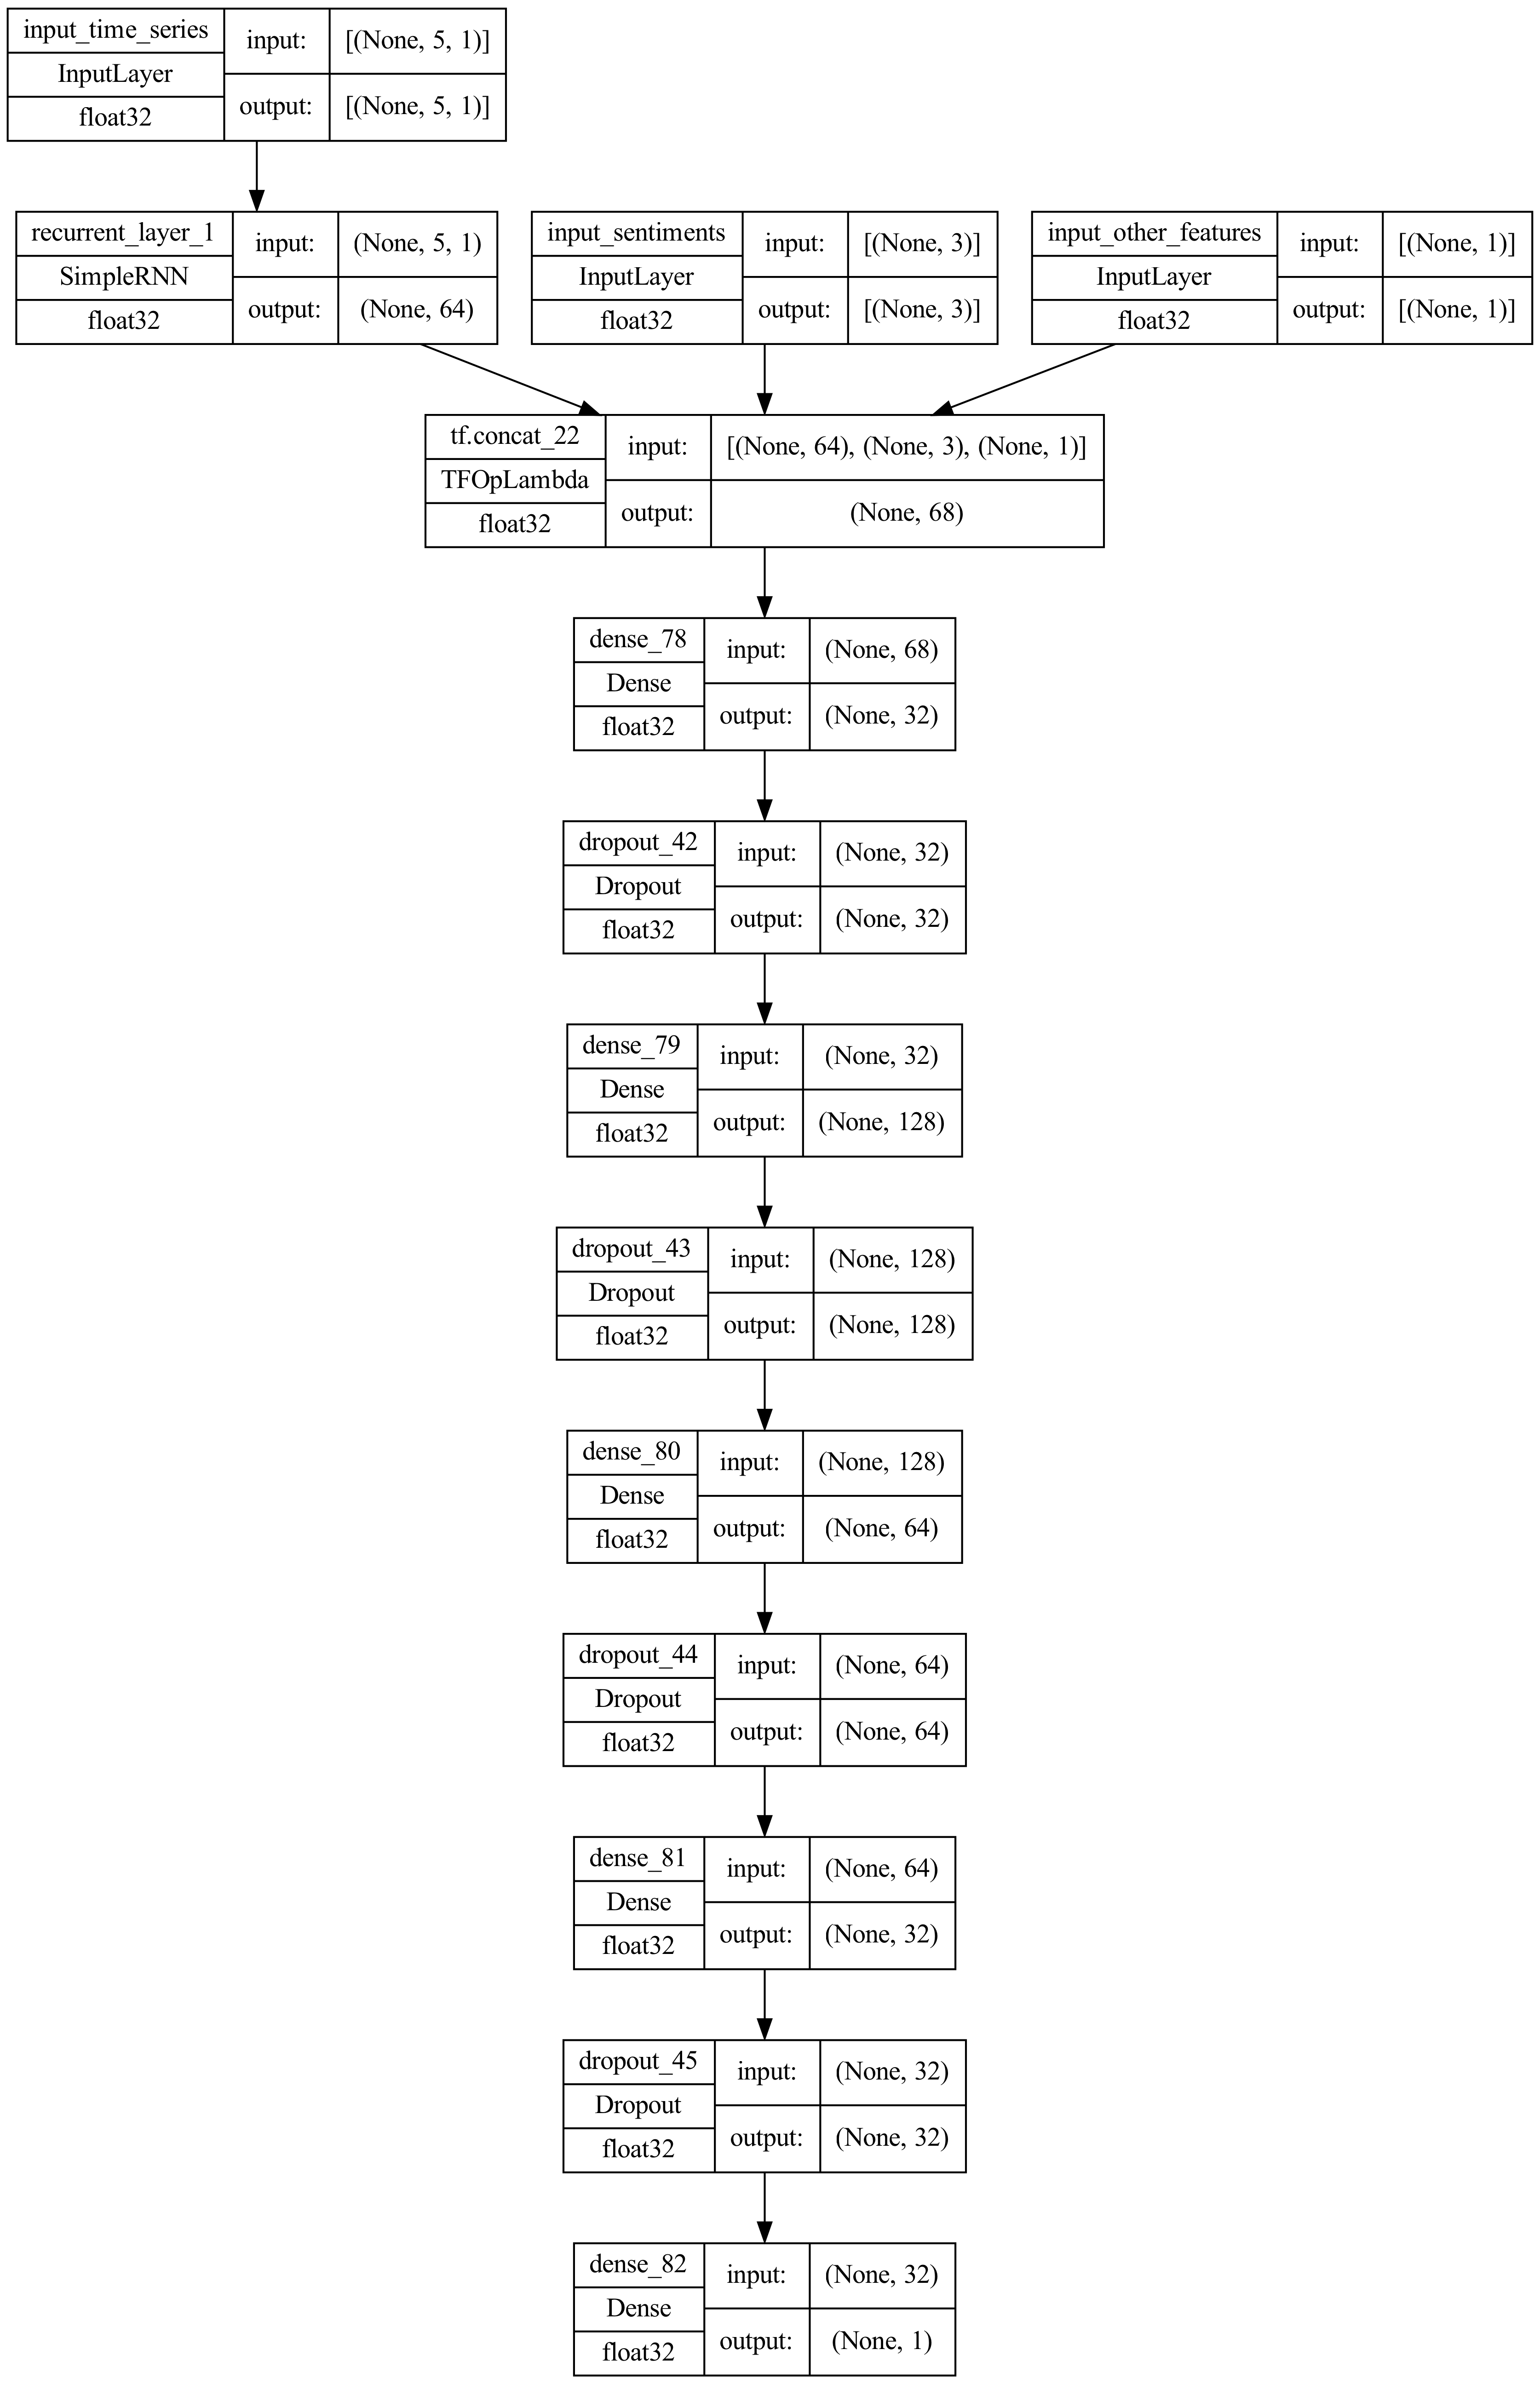

In [726]:
tf.keras.utils.plot_model(model,dpi=300,show_dtype=True,show_shapes = True)

# Loading data

In [479]:
df0 = pd.read_csv('MSFT_stock_data.csv')
df0 = df0.set_index('Date')
df0['target'] = df0.Close - df0.drift
sc = StandardScaler()
data_scaled = sc.fit_transform(df0) #scaling using sklearn gives list rather than DataFrame.
data_scaled = pd.DataFrame(data_scaled,columns = df0.columns) # we create a DataFrame from the above list
data_scaled.index = df0.index

In [480]:
sentiment_df = pd.read_csv('sentiment_data_frame.csv').set_index('date')

dates_sentiment = []
for date in sentiment_df.index:
    dates_sentiment.append(datetime.strptime(date,'%Y-%m-%d'))

sentiment_df['Date'] = dates_sentiment
sentiment_df = sentiment_df.set_index('Date')



dates_data = []
for date in data_scaled.index:
    dates_data.append(datetime.strptime(date[0:10],'%Y-%m-%d'))

data_scaled['Date'] = dates_data
df0['Date'] = dates_data
data_scaled = data_scaled.set_index('Date')
df0 = df0.set_index('Date')


df = pd.concat([data_scaled,sentiment_df],axis = 'columns') # combining the dataframes
df = df[np.isnan(df.Close)==False] # Remove all rows where we don't have stock information --- Weekends
df = df[np.isnan(df.negative) == False] # Removes last few days where we didn't gather sentiment data

In [481]:
df

,Open,High,Low,Close,Volume,drift,target,negative,neutral,positive
Date,,,,,,,,,,
2020-01-02,-1.941851,-1.956931,-1.902825,-1.908534,-0.674104,-1.512309,-0.006497,0.011839,0.962005,0.026156
2020-01-03,-1.951209,-1.972772,-1.908348,-1.949256,-0.788424,-1.509670,-0.051776,0.078713,0.418107,0.503180
2020-01-06,-1.976436,-1.990035,-1.940052,-1.940908,-0.811389,-1.507028,-0.046610,0.000710,0.795922,0.203369
2020-01-07,-1.930865,-1.978459,-1.923483,-1.970432,-0.749108,-1.504384,-0.080382,0.002264,0.651065,0.346672
2020-01-08,-1.938799,-1.955509,-1.910597,-1.919325,-0.285086,-1.501737,-0.031262,0.019571,0.776316,0.204114
...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.814158,1.829653,1.777813,1.731087,1.096877,1.924944,-0.709541,0.319927,0.480649,0.199424
2023-06-01,1.680442,1.779070,1.722643,1.819253,-0.358921,1.930728,-0.626377,0.298777,0.132570,0.568653
2023-06-02,1.855366,1.862395,1.888153,1.878592,-0.427996,1.936517,-0.572857,0.003831,0.791215,0.204954


In [482]:
train_time_series = []
train_sentiments = []
train_others = []
train_target = []
test_time_series = []
test_sentiments = []
test_others = []
test_target=[]
train_date = []
test_date = []
test_date_start = datetime.strptime('2023','%Y')
for i in range(lookback,len(df)):
    if df.index[i]<test_date_start:
        train_date.append(df.index[i])
        time_series = df.target[i-lookback:i].values.reshape(lookback,1)
        sentiment = np.array([df.negative[i],df.neutral[i],df.positive[i]]).reshape(3)
        other = np.array([0]).reshape(1)
        train_time_series.append(time_series)
        train_sentiments.append(sentiment)
        train_others.append(other)
        train_target.append(np.array(df.target[i]).reshape(1))
    if df.index[i]>=test_date_start:
        test_date.append(df.index[i])
        time_series = df.target[i-lookback:i].values.reshape(lookback,1)
        sentiment = np.array([df.negative[i],df.neutral[i],df.positive[i]]).reshape(3)
        other = np.array([0]).reshape(1)
        test_time_series.append(time_series)
        test_sentiments.append(sentiment)
        test_others.append(other)
        test_target.append(np.array(df.target[i]).reshape(1))

In [483]:
train_time_series = tf.convert_to_tensor(train_time_series)
test_time_series = tf.convert_to_tensor(test_time_series)
train_sentiments = tf.convert_to_tensor(train_sentiments)
test_sentiments = tf.convert_to_tensor(test_sentiments)
train_others = tf.convert_to_tensor(train_others)
test_others = tf.convert_to_tensor(test_others)
train_target = tf.convert_to_tensor(train_target)
test_target = tf.convert_to_tensor(test_target)

In [594]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=2e-5),metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history=model.fit(x=[train_time_series,train_sentiments,train_others],y=train_target,validation_data=([test_time_series,test_sentiments,test_others],test_target),epochs=200,verbose=1)

Epoch 1/200
24/24 [==============================] - 1s 14ms/step - loss: 0.0683 - root_mean_squared_error: 0.1699 - mean_absolute_error: 0.1233 - val_loss: 0.0708 - val_root_mean_squared_error: 0.1772 - val_mean_absolute_error: 0.1419
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0682 - root_mean_squared_error: 0.1696 - mean_absolute_error: 0.1225 - val_loss: 0.0707 - val_root_mean_squared_error: 0.1770 - val_mean_absolute_error: 0.1427
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0698 - root_mean_squared_error: 0.1746 - mean_absolute_error: 0.1288 - val_loss: 0.0715 - val_root_mean_squared_error: 0.1796 - val_mean_absolute_error: 0.1425
Epoch 4/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0683 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1247 - val_loss: 0.0712 - val_root_mean_squared_error: 0.1788 - val_mean_absolute_error: 0.1435
Epoch 5/200
24/24 [==============================] - 0s 4ms

Epoch 36/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0656 - root_mean_squared_error: 0.1658 - mean_absolute_error: 0.1218 - val_loss: 0.0704 - val_root_mean_squared_error: 0.1797 - val_mean_absolute_error: 0.1436
Epoch 37/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0679 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1229 - val_loss: 0.0692 - val_root_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.1423
Epoch 38/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0657 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1231 - val_loss: 0.0691 - val_root_mean_squared_error: 0.1762 - val_mean_absolute_error: 0.1412
Epoch 39/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0659 - root_mean_squared_error: 0.1670 - mean_absolute_error: 0.1228 - val_loss: 0.0687 - val_root_mean_squared_error: 0.1752 - val_mean_absolute_error: 0.1410
Epoch 40/200
24/24 [==============================] - 0s

Epoch 71/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0672 - root_mean_squared_error: 0.1739 - mean_absolute_error: 0.1281 - val_loss: 0.0682 - val_root_mean_squared_error: 0.1766 - val_mean_absolute_error: 0.1415
Epoch 72/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0636 - root_mean_squared_error: 0.1634 - mean_absolute_error: 0.1215 - val_loss: 0.0683 - val_root_mean_squared_error: 0.1772 - val_mean_absolute_error: 0.1417
Epoch 73/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0676 - root_mean_squared_error: 0.1752 - mean_absolute_error: 0.1284 - val_loss: 0.0681 - val_root_mean_squared_error: 0.1766 - val_mean_absolute_error: 0.1428
Epoch 74/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0685 - root_mean_squared_error: 0.1777 - mean_absolute_error: 0.1303 - val_loss: 0.0686 - val_root_mean_squared_error: 0.1781 - val_mean_absolute_error: 0.1427
Epoch 75/200
24/24 [==============================] - 0s

Epoch 106/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0613 - root_mean_squared_error: 0.1593 - mean_absolute_error: 0.1170 - val_loss: 0.0681 - val_root_mean_squared_error: 0.1794 - val_mean_absolute_error: 0.1441
Epoch 107/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0642 - root_mean_squared_error: 0.1682 - mean_absolute_error: 0.1227 - val_loss: 0.0693 - val_root_mean_squared_error: 0.1831 - val_mean_absolute_error: 0.1454
Epoch 108/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0688 - root_mean_squared_error: 0.1815 - mean_absolute_error: 0.1284 - val_loss: 0.0684 - val_root_mean_squared_error: 0.1803 - val_mean_absolute_error: 0.1459
Epoch 109/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0635 - root_mean_squared_error: 0.1660 - mean_absolute_error: 0.1209 - val_loss: 0.0681 - val_root_mean_squared_error: 0.1794 - val_mean_absolute_error: 0.1463
Epoch 110/200
24/24 [==============================]

24/24 [==============================] - 0s 4ms/step - loss: 0.0641 - root_mean_squared_error: 0.1704 - mean_absolute_error: 0.1251 - val_loss: 0.0668 - val_root_mean_squared_error: 0.1782 - val_mean_absolute_error: 0.1431
Epoch 141/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0648 - root_mean_squared_error: 0.1725 - mean_absolute_error: 0.1279 - val_loss: 0.0665 - val_root_mean_squared_error: 0.1775 - val_mean_absolute_error: 0.1428
Epoch 142/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0644 - root_mean_squared_error: 0.1717 - mean_absolute_error: 0.1259 - val_loss: 0.0666 - val_root_mean_squared_error: 0.1780 - val_mean_absolute_error: 0.1422
Epoch 143/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0618 - root_mean_squared_error: 0.1638 - mean_absolute_error: 0.1203 - val_loss: 0.0661 - val_root_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.1425
Epoch 144/200
24/24 [==============================] - 0s 3ms/step

Epoch 175/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0615 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1229 - val_loss: 0.0649 - val_root_mean_squared_error: 0.1754 - val_mean_absolute_error: 0.1398
Epoch 176/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0609 - root_mean_squared_error: 0.1637 - mean_absolute_error: 0.1225 - val_loss: 0.0648 - val_root_mean_squared_error: 0.1751 - val_mean_absolute_error: 0.1401
Epoch 177/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0628 - root_mean_squared_error: 0.1693 - mean_absolute_error: 0.1219 - val_loss: 0.0650 - val_root_mean_squared_error: 0.1758 - val_mean_absolute_error: 0.1424
Epoch 178/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0603 - root_mean_squared_error: 0.1620 - mean_absolute_error: 0.1197 - val_loss: 0.0649 - val_root_mean_squared_error: 0.1758 - val_mean_absolute_error: 0.1404
Epoch 179/200
24/24 [==============================]

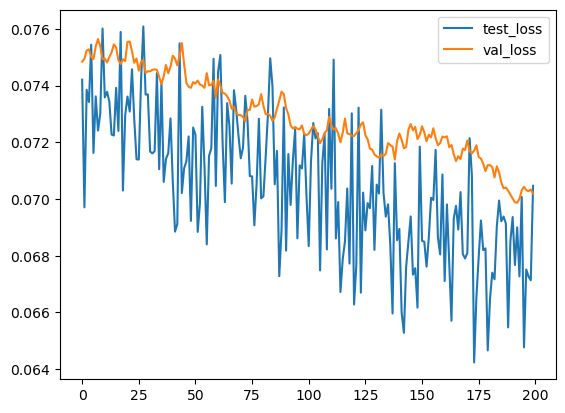

In [580]:
plt.plot(history.history['loss'],label='test_loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [595]:
train_prediction = model.predict([train_time_series,train_sentiments,train_others])
prediction = model.predict([test_time_series,test_sentiments,test_others])

4/4 [==============================] - 0s 2ms/step


## Converting back to the stock price

In [596]:
pred_df = pd.DataFrame(prediction,columns=['prediction'])
pred_df['Date'] = test_date
pred_df = pred_df.set_index('Date')

train_df = pd.DataFrame(train_prediction,columns=['prediction'])
train_df['Date'] = train_date
train_df = train_df.set_index('Date')

In [597]:
target_prediction = tf.concat([train_prediction,prediction],axis=0)
dates = train_date+test_date

In [598]:
sc_target = StandardScaler()
sc_target.fit_transform(np.array(df0.target.values).reshape(-1,1))
target_pred_rescaled = sc_target.inverse_transform(target_prediction)

In [599]:
prediction_df = pd.DataFrame(target_pred_rescaled,columns=['target_prediction'])
prediction_df['Date'] = dates
prediction_df = prediction_df.set_index('Date')

In [600]:
final_df = pd.concat([df0,prediction_df],axis = 'columns')
final_df = final_df[np.isnan(final_df.target_prediction)==False]
final_df['close_prediction'] = final_df.drift+final_df.target_prediction

In [601]:
final_df

,Open,High,Low,Close,Volume,drift,target,target_prediction,close_prediction
Date,,,,,,,,,
2020-01-09,156.602558,156.970265,155.818773,156.844467,21385000,173.245475,-16.401008,-19.024938,154.220538
2020-01-10,157.550859,157.937908,155.963918,156.118744,20725900,173.403962,-17.285218,-17.250717,156.153246
2020-01-13,156.525142,158.024984,156.041323,157.995956,21626500,173.562594,-15.566638,-16.298488,157.264106
2020-01-14,158.102413,158.305623,156.486459,156.883194,23477400,173.721371,-16.838177,-16.201950,157.519420
2020-01-15,157.357325,158.634615,157.308955,157.899200,21417900,173.880293,-15.981092,-15.948155,157.932138
...,...,...,...,...,...,...,...,...,...
2023-05-31,332.290009,335.940002,327.329987,328.390015,45950600,377.921303,-49.531288,-50.755455,327.165848
2023-06-01,325.929993,333.529999,324.720001,332.579987,26773900,378.267029,-45.687043,-50.646506,327.620523
2023-06-02,334.250000,337.500000,332.549988,335.399994,25864000,378.613072,-43.213078,-48.606539,330.006533


# Evaluating performance

First, we will plot prediction and actual closing price

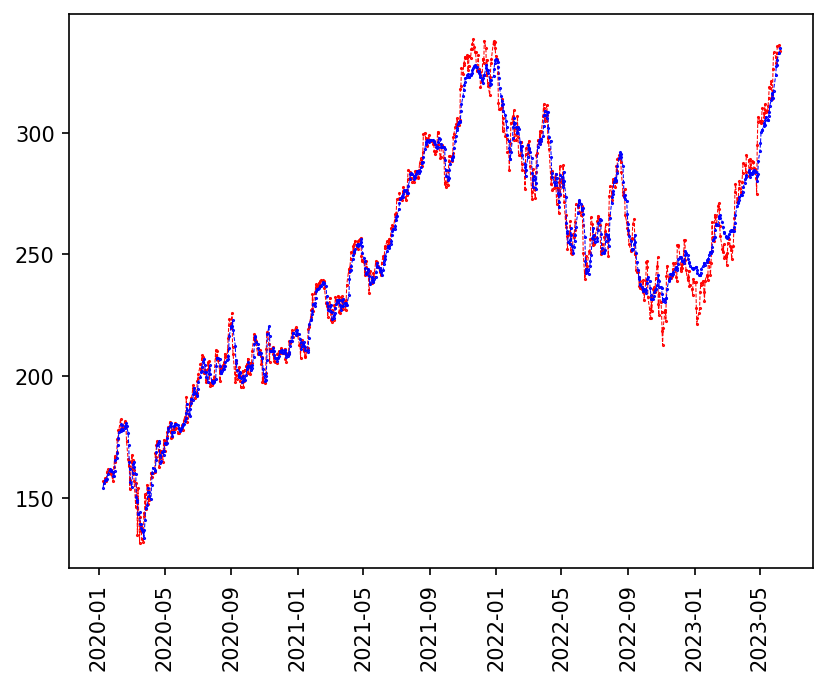

In [602]:
plt.figure(dpi=150)
plt.plot(final_df.index,final_df.Close,'--.r',linewidth=0.5,markersize=1)
plt.plot(final_df.index,final_df.close_prediction,'--.b',linewidth=0.5,markersize=1)
plt.xticks(rotation='vertical')
plt.show()

Now, let us plot for 2023. The model was not trained on this data.

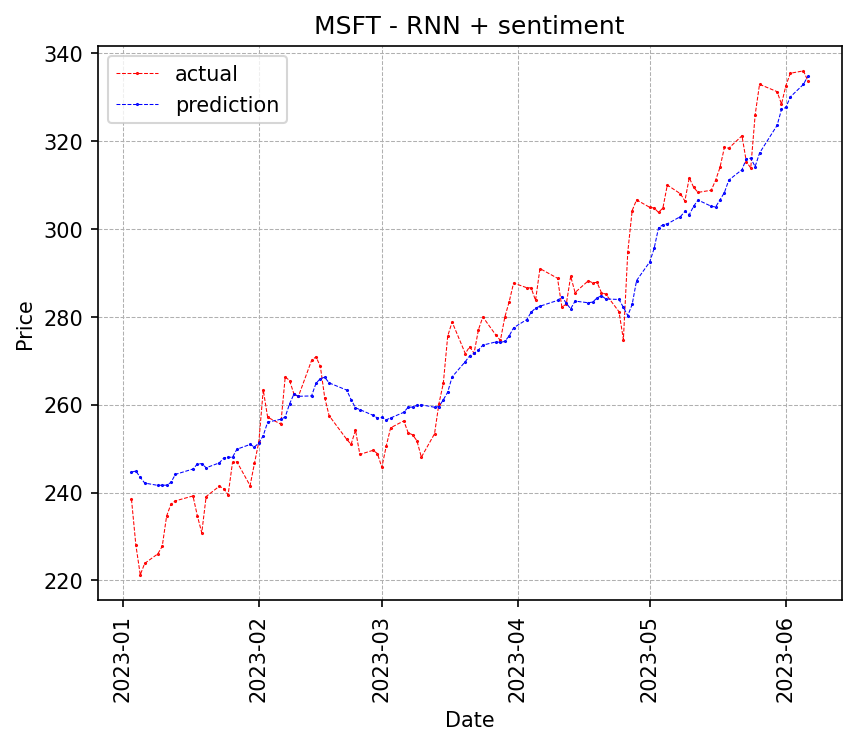

In [711]:
plt.figure(dpi=150)
plt.plot(final_df.index[final_df.index>test_date_start],final_df.Close[final_df.index>test_date_start],'--.r',linewidth=0.5,markersize=1,label='actual')
plt.plot(final_df.index[final_df.index>test_date_start],final_df.close_prediction[final_df.index>test_date_start],'--.b',linewidth=0.5,markersize=1,label='prediction')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT - RNN + sentiment')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [609]:
error_fractional = np.sqrt(mean_squared_error(final_df.Close[final_df.index>test_date_start],final_df.close_prediction[final_df.index>test_date_start]))/np.mean(final_df.Close[final_df.index>test_date_start])
print(error_fractional)

0.029536827106232788


In [610]:
error_rmse = np.sqrt(np.sum(((final_df.Close[final_df.index>test_date_start]-final_df.close_prediction[final_df.index>test_date_start]).values**2))/len(final_df.Close[final_df.index>test_date_start]))
print(error_rmse)

8.138645121855367


# Comparison with other models

We will now compare the performance of our model with:
1. Similar model without sentiment data.
2. Moving average model


In [611]:
## RNN without sentiment

In [612]:
def rnn_model(lookback):
    #input layers
    lstm_input = Input(shape=(lookback,1), name='input_time_series')
    
    #recurrent layer
    recurrent_layer_1 = SimpleRNN(64,activation='tanh',return_sequences=False, return_state = False,name='recurrent_layer_1',recurrent_dropout=0.01,dropout=0.01,kernel_regularizer=tf.keras.regularizers.L2(0.001))(lstm_input) # 128 neurons in the LSTM layer
    
    
    #output layer
    output_layer = Dense(1)(recurrent_layer_1)
    
    model = tf.keras.Model(inputs=lstm_input,outputs = output_layer)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4),metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    return model

In [613]:
simplernn_model = rnn_model(lookback)

In [614]:
simplernn_model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_time_series (InputLay  [(None, 5, 1)]           0         
 er)                                                             
                                                                 
 recurrent_layer_1 (SimpleRN  (None, 64)               4224      
 N)                                                              
                                                                 
 dense_83 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


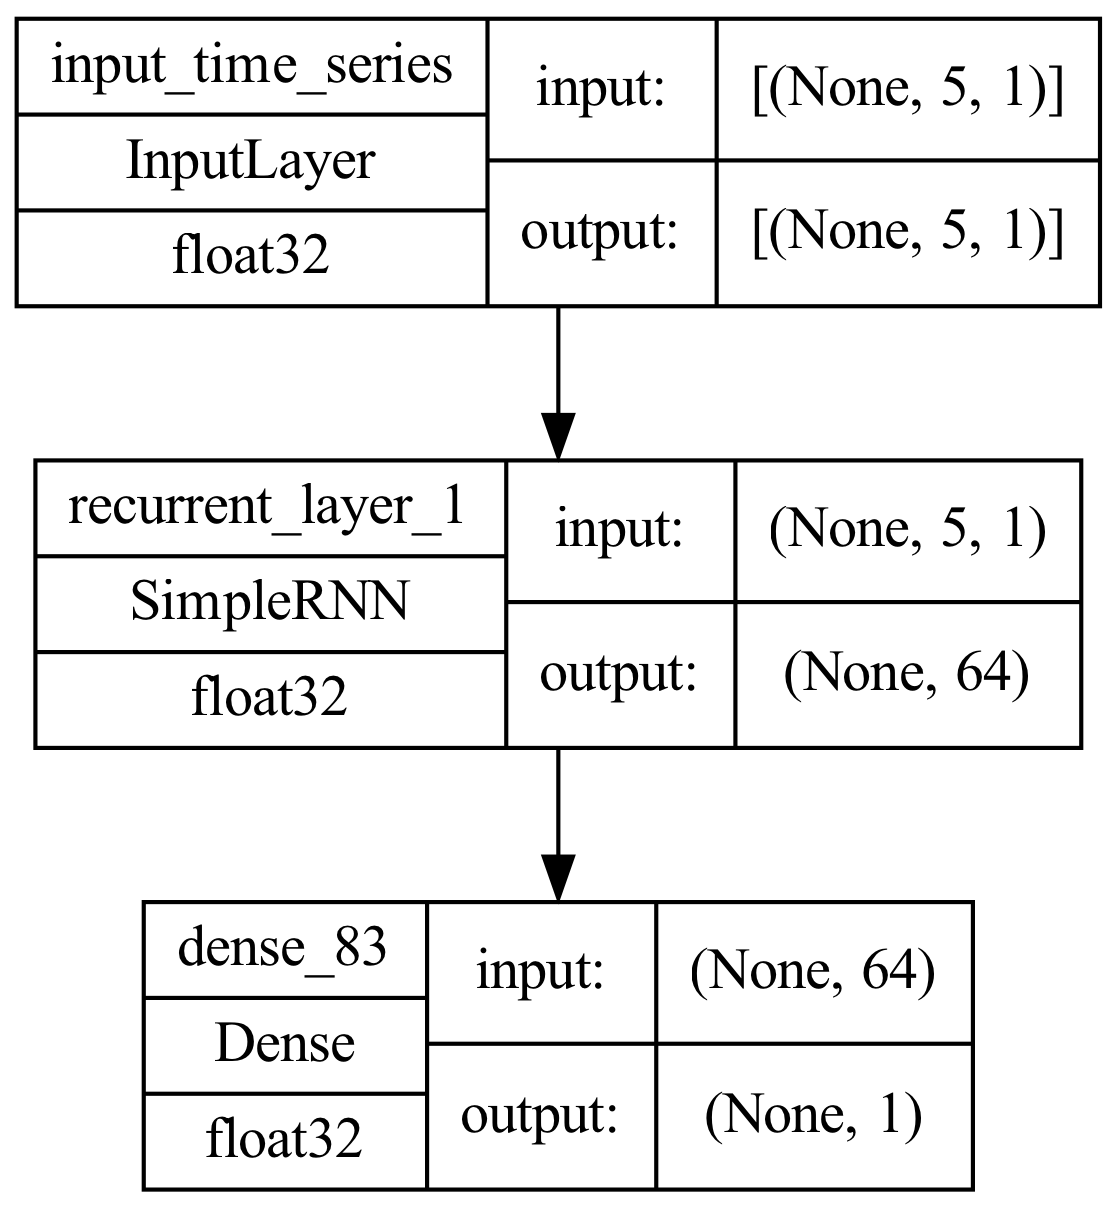

In [725]:
tf.keras.utils.plot_model(simplernn_model,dpi=300,show_dtype=True,show_shapes = True)

In [617]:
simplernn_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=2e-5),metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history=simplernn_model.fit(x=train_time_series,y=train_target,validation_data=(test_time_series,test_target),epochs=200,verbose=1)

Epoch 1/200
24/24 [==============================] - 1s 11ms/step - loss: 0.0196 - root_mean_squared_error: 0.1332 - mean_absolute_error: 0.1002 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1441 - val_mean_absolute_error: 0.1092
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0209 - root_mean_squared_error: 0.1379 - mean_absolute_error: 0.1037 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1437 - val_mean_absolute_error: 0.1088
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0224 - root_mean_squared_error: 0.1432 - mean_absolute_error: 0.1054 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1435 - val_mean_absolute_error: 0.1086
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1312 - mean_absolute_error: 0.0983 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1448 - val_mean_absolute_error: 0.1097
Epoch 5/200
24/24 [==============================] - 0s 3ms

Epoch 36/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0198 - root_mean_squared_error: 0.1338 - mean_absolute_error: 0.1015 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1373 - val_mean_absolute_error: 0.1035
Epoch 37/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1376 - mean_absolute_error: 0.1030 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1380 - val_mean_absolute_error: 0.1041
Epoch 38/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1373 - mean_absolute_error: 0.1021 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1373 - val_mean_absolute_error: 0.1036
Epoch 39/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0182 - root_mean_squared_error: 0.1280 - mean_absolute_error: 0.0967 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1367 - val_mean_absolute_error: 0.1031
Epoch 40/200
24/24 [==============================] - 0s

Epoch 71/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0204 - root_mean_squared_error: 0.1360 - mean_absolute_error: 0.0989 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1360 - val_mean_absolute_error: 0.1027
Epoch 72/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1335 - mean_absolute_error: 0.0949 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1346 - val_mean_absolute_error: 0.1016
Epoch 73/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0212 - root_mean_squared_error: 0.1392 - mean_absolute_error: 0.0987 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1371 - val_mean_absolute_error: 0.1038
Epoch 74/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1272 - mean_absolute_error: 0.0943 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1349 - val_mean_absolute_error: 0.1018
Epoch 75/200
24/24 [==============================] - 0s

Epoch 106/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1389 - mean_absolute_error: 0.0988 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1304 - val_mean_absolute_error: 0.0985
Epoch 107/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0201 - root_mean_squared_error: 0.1353 - mean_absolute_error: 0.0987 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1323 - val_mean_absolute_error: 0.0998
Epoch 108/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1335 - mean_absolute_error: 0.0981 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1315 - val_mean_absolute_error: 0.0992
Epoch 109/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0223 - root_mean_squared_error: 0.1429 - mean_absolute_error: 0.0986 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1331 - val_mean_absolute_error: 0.1006
Epoch 110/200
24/24 [==============================]

24/24 [==============================] - 0s 3ms/step - loss: 0.0183 - root_mean_squared_error: 0.1283 - mean_absolute_error: 0.0937 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1305 - val_mean_absolute_error: 0.0985
Epoch 141/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1404 - mean_absolute_error: 0.0976 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1294 - val_mean_absolute_error: 0.0976
Epoch 142/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0217 - root_mean_squared_error: 0.1410 - mean_absolute_error: 0.0985 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1342 - val_mean_absolute_error: 0.1018
Epoch 143/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0185 - root_mean_squared_error: 0.1293 - mean_absolute_error: 0.0956 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1280 - val_mean_absolute_error: 0.0967
Epoch 144/200
24/24 [==============================] - 0s 3ms/step

Epoch 175/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0187 - root_mean_squared_error: 0.1299 - mean_absolute_error: 0.0937 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1263 - val_mean_absolute_error: 0.0953
Epoch 176/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1318 - mean_absolute_error: 0.0958 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1288 - val_mean_absolute_error: 0.0971
Epoch 177/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0160 - root_mean_squared_error: 0.1190 - mean_absolute_error: 0.0890 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1257 - val_mean_absolute_error: 0.0951
Epoch 178/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1231 - mean_absolute_error: 0.0913 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1264 - val_mean_absolute_error: 0.0954
Epoch 179/200
24/24 [==============================]

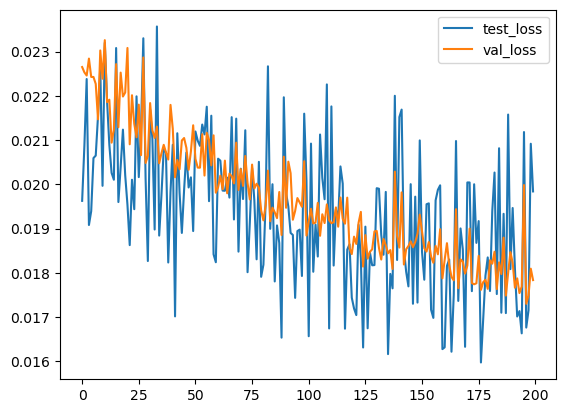

In [618]:
plt.plot(history.history['loss'],label='test_loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [636]:
prediction2 = simplernn_model.predict(test_time_series)
train2_prediction = simplernn_model.predict(train_time_series)

pred2_df = pd.DataFrame(prediction2,columns=['prediction'])
pred2_df['Date'] = test_date
pred2_df = pred2_df.set_index('Date')

train2_df = pd.DataFrame(train2_prediction,columns=['prediction'])
train2_df['Date'] = train_date
train2_df = train2_df.set_index('Date')

target2_prediction = tf.concat([train2_prediction,prediction2],axis=0)
dates = train_date+test_date

target2_pred_rescaled = sc_target.inverse_transform(target2_prediction)

prediction2_df = pd.DataFrame(target2_pred_rescaled,columns=['target_prediction'])
prediction2_df['Date'] = dates
prediction2_df = prediction2_df.set_index('Date')

final2_df = pd.concat([df0,prediction2_df],axis = 'columns').copy()
final2_df = final2_df[np.isnan(final2_df.target_prediction)==False]
final2_df['close_prediction'] = final2_df.drift+final2_df.target_prediction

final2_df

24/24 [==============================] - 0s 1ms/step


,Open,High,Low,Close,Volume,drift,target,target_prediction,close_prediction
Date,,,,,,,,,
2020-01-09,156.602558,156.970265,155.818773,156.844467,21385000,173.245475,-16.401008,-18.952343,154.293133
2020-01-10,157.550859,157.937908,155.963918,156.118744,20725900,173.403962,-17.285218,-17.300111,156.103852
2020-01-13,156.525142,158.024984,156.041323,157.995956,21626500,173.562594,-15.566638,-17.053095,156.509499
2020-01-14,158.102413,158.305623,156.486459,156.883194,23477400,173.721371,-16.838177,-16.061853,157.659518
2020-01-15,157.357325,158.634615,157.308955,157.899200,21417900,173.880293,-15.981092,-16.228514,157.651779
...,...,...,...,...,...,...,...,...,...
2023-05-31,332.290009,335.940002,327.329987,328.390015,45950600,377.921303,-49.531288,-48.740781,329.180522
2023-06-01,325.929993,333.529999,324.720001,332.579987,26773900,378.267029,-45.687043,-49.618130,328.648899
2023-06-02,334.250000,337.500000,332.549988,335.399994,25864000,378.613072,-43.213078,-47.926153,330.686919


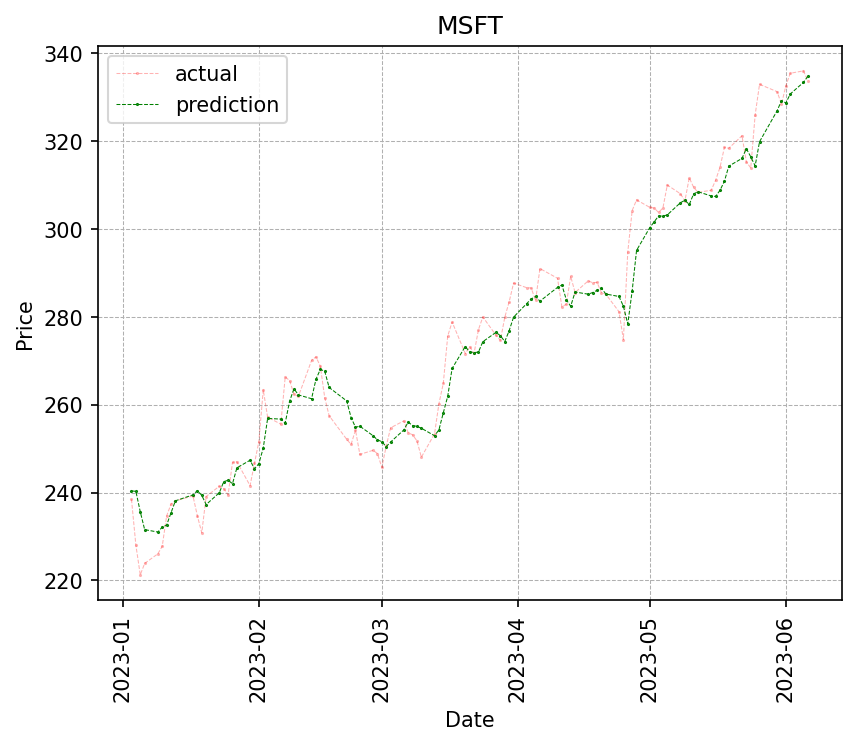

In [716]:
plt.figure(dpi=150)
plt.plot(final2_df.index[final2_df.index>test_date_start],final2_df.Close[final2_df.index>test_date_start],'--.r',linewidth=0.5,markersize=1,label='actual',alpha = 0.3)
plt.plot(final2_df.index[final2_df.index>test_date_start],final2_df.close_prediction[final2_df.index>test_date_start],'--.g',linewidth=0.5,markersize=1,label='prediction')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [638]:
error_fractional = np.sqrt(mean_squared_error(final2_df.Close[final2_df.index>test_date_start],final2_df.close_prediction[final2_df.index>test_date_start]))/np.mean(final2_df.Close[final2_df.index>test_date_start])
print(f'''fractional error= {error_fractional}''')

error_rmse = np.sqrt(np.sum(((final2_df.Close[final2_df.index>test_date_start]-final2_df.close_prediction[final2_df.index>test_date_start]).values**2))/len(final2_df.Close[final2_df.index>test_date_start]))
print(error_rmse)

fractional error= 0.021248208236997877
5.854780057933785


In [642]:
final2_df.close_prediction - final_df.close_prediction

Date
2020-01-09    0.072595
2020-01-10   -0.049394
2020-01-13   -0.754607
2020-01-14    0.140098
2020-01-15   -0.280359
                ...   
2023-05-31    2.014674
2023-06-01    1.028376
2023-06-02    0.680387
2023-06-05    0.440892
2023-06-06   -0.016669
Name: close_prediction, Length: 858, dtype: float64

This model works better than the sentiment model

## Moving average models

In [718]:
n=10
avg = []
ema = [0]
k = 2/(n+1)
add = 0
for i,a in enumerate(df0.Close):
    if i < n:
        avg.append(0)
        ema.append(0)
    else: 
        avg.append(add)
        add = add - (df0.Close[i-n]/n)
        ema.append(k*a + (1-k)*ema[-1])
    add += a/n
ema.pop()

327.43618966190786

In [719]:
ma_df = df0.copy()

In [720]:
ma_df['SMA'] = avg
ma_df['EMA'] = ema
ma_df

,Open,High,Low,Close,Volume,drift,target,SMA,EMA
Date,,,,,,,,,
2020-01-02,153.641577,155.528468,153.206143,155.422028,22622100,172.455212,-17.033184,0.000000,0.000000
2020-01-03,153.196476,154.773716,152.944880,153.486755,21116200,172.612976,-19.126220,0.000000,0.000000
2020-01-06,151.996577,153.951210,151.445017,153.883469,20813700,172.770884,-18.887415,0.000000,0.000000
2020-01-07,154.164119,154.502783,152.228842,152.480423,21634100,172.928936,-20.448513,0.000000,0.000000
2020-01-08,153.786731,155.596225,152.838450,154.909195,27746500,173.087134,-18.177939,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2023-06-05,335.220001,338.559998,334.660004,335.940002,21307100,378.959431,-43.019429,325.502002,326.400483
2023-06-06,335.329987,335.369995,332.170013,333.679993,20396200,379.306107,-45.626114,327.262003,328.134941
2023-06-07,331.649994,334.489990,322.500000,323.380005,40717100,379.653100,-56.273095,328.512003,329.143133


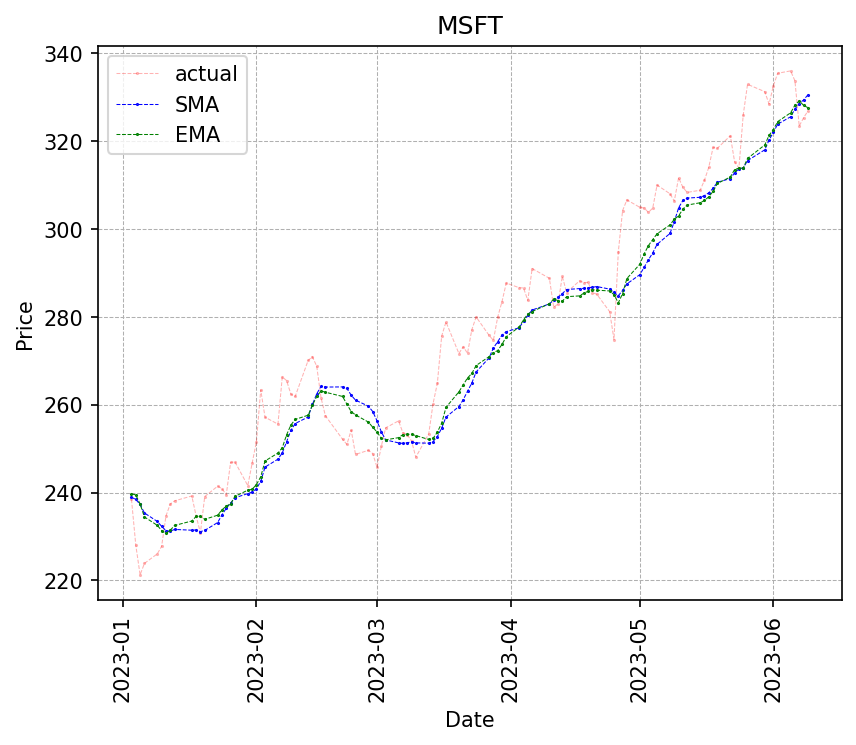

In [721]:
plt.figure(dpi=150)
plt.plot(df0.index[ma_df.index>test_date_start],ma_df.Close[df0.index>test_date_start],'--.r',linewidth=0.5,markersize=1,label='actual',alpha=0.3)
plt.plot(ma_df.index[df0.index>test_date_start],ma_df.SMA[df0.index>test_date_start],'--.b',linewidth=0.5,markersize=1,label='SMA')
plt.plot(ma_df.index[df0.index>test_date_start],ma_df.EMA[df0.index>test_date_start],'--.g',linewidth=0.5,markersize=1,label='EMA')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [722]:
error_fractional = np.sqrt(mean_squared_error(ma_df.Close[ma_df.index>test_date_start],ma_df.SMA[ma_df.index>test_date_start]))/np.mean(ma_df.Close[ma_df.index>test_date_start])
print(f'''Errors for simple moving average:
fractional error= {error_fractional}''')

error_rmse = np.sqrt(np.sum(((ma_df.Close[ma_df.index>test_date_start]-ma_df.SMA[ma_df.index>test_date_start]).values**2))/len(ma_df.Close[ma_df.index>test_date_start]))
print(error_rmse)

Errors for simple moving average:
fractional error= 0.033399821872719906
9.248245367601116


In [723]:
error_fractional = np.sqrt(mean_squared_error(ma_df.Close[ma_df.index>test_date_start],ma_df.EMA[ma_df.index>test_date_start]))/np.mean(ma_df.Close[ma_df.index>test_date_start])
print(f'''Errors for Exponential moving average:
fractional error= {error_fractional}''')

error_rmse = np.sqrt(np.sum(((ma_df.Close[ma_df.index>test_date_start]-ma_df.EMA[ma_df.index>test_date_start]).values**2))/len(ma_df.Close[ma_df.index>test_date_start]))
print(error_rmse)

Errors for Exponential moving average:
fractional error= 0.030623840381724696
8.479589832177082
